# Домашнее задание "Элементарные методы анализа временных рядов"

Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

# Решение

In [1]:
import pandas
from matplotlib import pyplot

In [2]:
def get_female_births_series():
    return pandas.read_csv('Series/daily-total-female-births-in-cal.csv')

def get_airlines_passengers_series():
    return pandas.read_csv('Series/international-airline-passengers.csv')

female_births_series = get_female_births_series()
airlines_passengers_series = get_airlines_passengers_series()

### Скользящее среднее

Пробуем посмотртеть на данные без учета сезонности

In [3]:
def moving_average(series, rolling):
    if not isinstance(series, pandas.Series):
        series = pandas.Series(series)
    return series.rolling(rolling).mean()

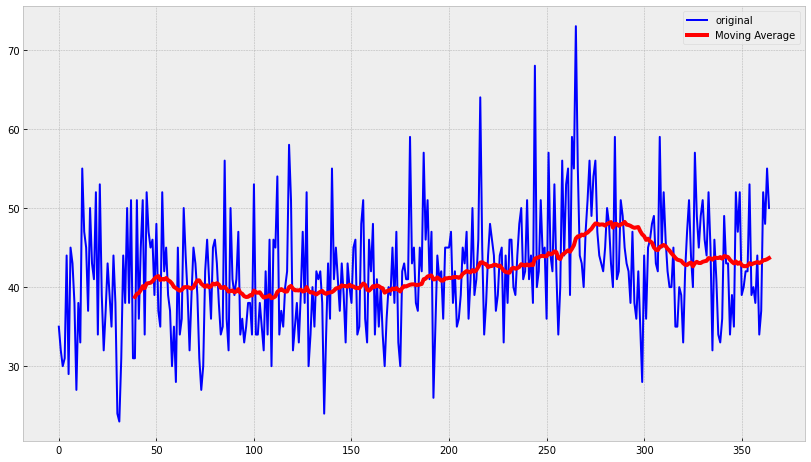

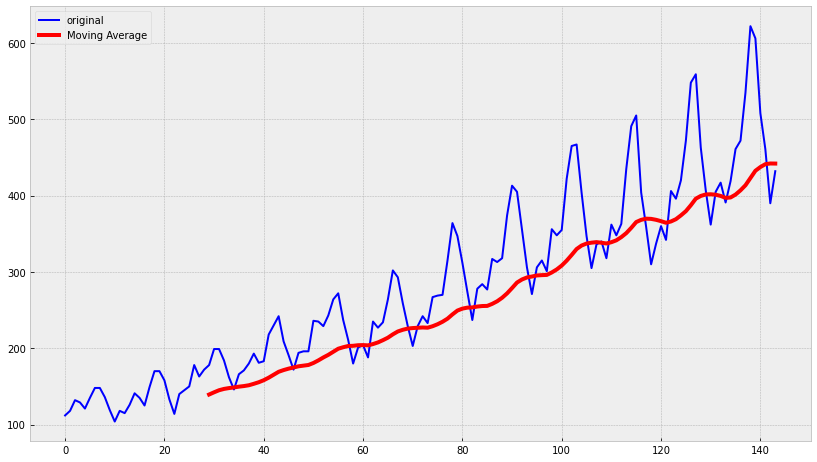

In [4]:
def show_moving_average_graph(value_count, rolling):
    series = moving_average(value_count, rolling)

    with pyplot.style.context('bmh'):
        pyplot.figure(figsize=(14, 8))
        pyplot.plot(
            value_count,
            color='blue',
            label='original')
        pyplot.plot(series, color='red', linewidth='4', label='Moving Average')
        pyplot.legend()
        pyplot.show()

show_moving_average_graph(
    value_count=female_births_series['Count'],
    rolling=40)

show_moving_average_graph(
    value_count=airlines_passengers_series['Count'],
    rolling=30)

### Хольт-Винтерс

Пробуем посмотртет на данные с учетом тренда и сезоности

In [5]:
def initial_trend(i, series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(i, series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m * trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

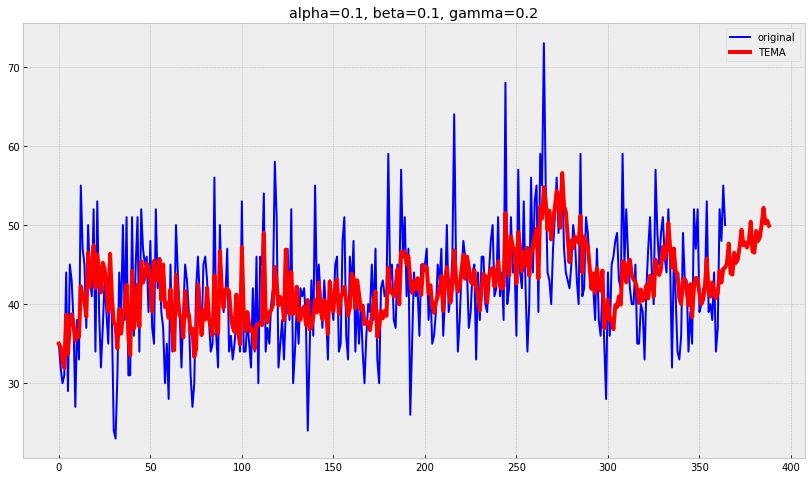

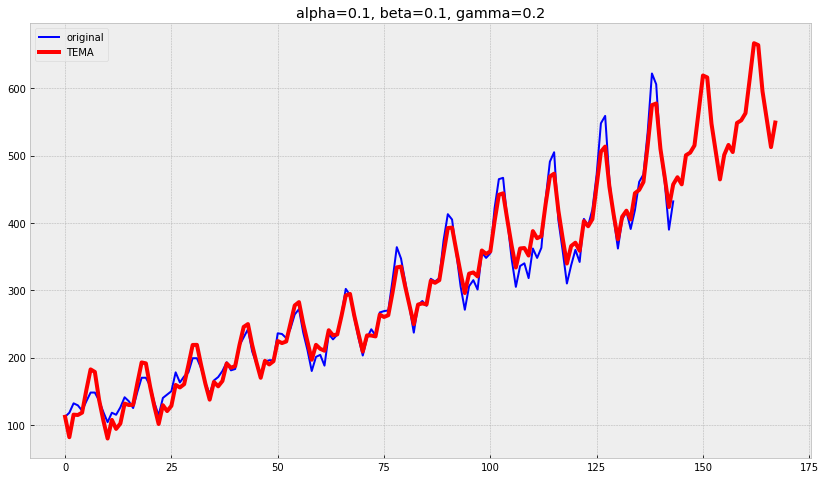

In [6]:
def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with pyplot.style.context('bmh'):
        pyplot.figure(figsize=(14, 8))
        pyplot.plot(ser_to_plot, color='blue',label='original')
        pyplot.plot(tema, color='red', linewidth='4', label='TEMA')
        pyplot.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        pyplot.legend()

plot_tema(
    alpha=0.1,
    beta=0.1,
    gamma=0.2,
    ser=female_births_series['Count'],
    ser_to_plot=female_births_series['Count'])

plot_tema(
    alpha=0.1,
    beta=0.1,
    gamma=0.2,
    ser=airlines_passengers_series['Count'],
    ser_to_plot=airlines_passengers_series['Count'])